## __<font color=blue>Google</font> Data Analytics Case Study : Cyclistic__

### Case Study Backdrop
As a junior data analyst working under Cyclistic's marketing team in Chicago, this assignment involves understanding,cleaning ,preprocessing, exploring , analysing and visualizing relevant data to identify trends that will assist the marketing team to gather relevelant uncovered insights and present the findings and counsel to the company director and executives.

### Project Scope






    

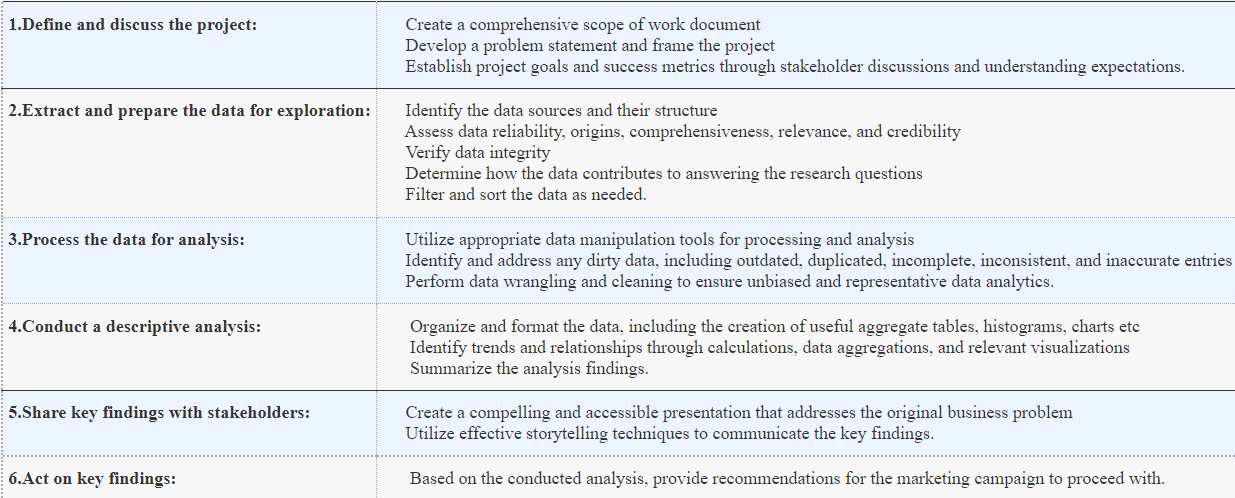

### Company background:
#### Current business model:
    
Product: The product offered is a bike-sharing service with geotracked and network locked bikes available throughout Chicago.

Customer types and revenue model: The customer base consists of two main categories: members, who are annual subscribers, and casual riders, who make single-ride or full-day purchases. The revenue model is based on these customer segments.

Competitive advantages: The company possesses competitive advantages in terms of bicycle variety, catering to a wide range of consumer segments, and pricing flexibility, allowing for adaptable pricing options.

#### Product info:
   1.Features more than 5,800 bicycles and 600 docking stations.</br>
   2.The majority of riders opt for traditional bikes.</br>
   3.Also offering reclining bikes, hand tricycles, and cargo bikes</br>
   4.8% of total riders use the assistive options.</br>
   5.About 30% of users use bikes to commute to work each day</br>
   6.Cyclistic users are more likely to ride for leisure.</br>
    

Problem Statement

The Chicago based company wants to migrate a huge portion of its customer from traditional casual customers to a bigger chunk of yearly subscribers.The existing marketing management believes that the existing casual user database acts as a plausible domain to expand their vision. If this proposed strategy works then the marketing campaign may lead to a more dependable sustainable revenue.The analyst needs to analyse the stark differences between the existin casual and yearly riders and look for concrete evidences to help the marketing strategy case.

Goals and Expectations

Analysing and visualizing relevant data to identify trends that will assist the marketing team to gather relevelant uncovered insights and present the findings and counsel to the company director and executives

Data Source and Organization

The data we'll be using was extracted using a helper dataset that was retrieved from [this](https://divvy-tripdata.s3.amazonaws.com/index.html) page and used to filter out any inaccurate data in our main dataset. 
Cyclistic company is fictional and this data set is used for the case study.
The data presented to us contains data collected from various points over a due course of time where each point represents possibly a single trip from docking point A to docking point B.
An initial look at the data doesn't give us sufficient reasons to deduct why the casual riders and annual subscribers.
Here the data provided to us spans through the period of a year.The file type exported is csv(comma seperated values) 

Data Quality Assessment

The sourcing of the data is from a first party group without any data integrity problems from third parties.The data is also comprehensive and free of any errors.

Integrity


The data is in a cloud repository that is managed by authorized employees and is secure by a trusted and well known global cloud services provider.

Filtering

The data has already been filtered between July 2020 and June 2021

## Preprocessing Logs ##

In [1]:
import numpy as np                        # efficient data types
import csv                                # csv handling
import os                                 # data file path handling
import glob                               # pathnames matching
import pandas as pd                       # data manipulation and analysis
import warnings                           # eliminate markdown warnings
import geopandas as gpd                   # geographical visualizations
import matplotlib.pyplot as plt           # plotting visuals
import seaborn as sns                     # visualization module
from shapely.geometry import Point        # plotting gps coordinates
import difflib                            # comparing strings
import re                                 # pattern matching 


# global settings
sns.set(style="white")
%matplotlib inline
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 100)

def cols_mem_usage(*args: str) -> None:
    """Print dataframe column's memory usage in megabytes."""
    df_mem_usage = df.memory_usage(deep = True)
    for col_name in list(args):
        print(f"{col_name} total memory usage: {df_mem_usage[col_name]/1_000_000}MB")
        
"""
pandas is inadvertantly converting integers into floats (i.e. 1 -> 1.0) on csv reads, so
this is mainly to handle comparisons that should hold true like '1' == '1.0'  
while accounting for strings without digits
"""
def try_int(x: str) -> str:
    """Attempt to convert a string into an integer, and back into a string to remove decimals."""
    try:
        return str(int(x))
    except ValueError:
        return x

Setting up Library modules and helper functions

Data preview

Observing a single row in the data to check and mark the necessary header columns in the csv

In [2]:
def get_csv_peek(fp: str) -> pd.DataFrame:   
   
    with open(fp) as csvfile:
        reader = csv.reader(csvfile)
        column_headers = next(reader) 
        first_row = next(reader)
        return pd.DataFrame(data = [first_row], columns = column_headers)

get_csv_peek("202007-divvy-tripdata.csv")

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,762198876D69004D,docked_bike,2020-07-09 15:22:02,2020-07-09 15:25:52,Ritchie Ct & Banks St,180,Wells St & Evergreen Ave,291,41.906866,-87.626217,41.906724,-87.63483,member


All the columns are necessary for our analysis so we wouldn't be dropping any of them.

### Checking Dataset Size

In [3]:
import os

def get_files_total_size() -> float:
    """Find the total dataset size by summing each individual file's size"""
    data_folder_path = os.getcwd()  # Assuming the CSV file is in the current directory
    files = os.listdir(data_folder_path)
    total_size = 0
    for f in files:
        file_path = os.path.join(data_folder_path, f)
        total_size += os.path.getsize(file_path)
    
    return round(total_size / 1_000_000, 2)

print(f"Total dataset size: {get_files_total_size()} Megabytes")





Total dataset size: 98.39 Megabytes


### Merging the dataset into a single frame

In [4]:
def get_merged_df(data_folder_path: str) -> pd.DataFrame:
    """Merge data files into a single dataframe."""
    files = list(os.listdir(data_folder_path))
    file_paths = [data_folder_path + f for f in files]
    #load all files
    df_per_file = (pd.read_csv(fp, 
                               low_memory = False, 
                               parse_dates = ['started_at', 'ended_at'],
                               infer_datetime_format = True,
                               memory_map = True)
                  for fp in file_paths)
    return pd.concat(df_per_file, ignore_index = True)

df = get_merged_df(os.getcwd() + "\\uncleaned_data\\")

### Loading the Chicago dataset 

Loading the into the data [Divvy_Bicycle_Stations](https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations/bbyy-e7gq/data) to get the utmost and latest data of the docking stations to our advantage

_We'll extract only relevant columns to us from the Divvy csv data namely - ID	Station Name	Total Docks	Docks in Service	Status	Latitude	Longitude	Location_

In [5]:
stations_df = pd.read_csv("Divvy_Bicycle_Stations.csv", usecols = ['ID', 'Station Name', 'Latitude', 'Longitude'], index_col = 'Station Name')
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1419 entries, Troy St & Jackson Blvd to Baltimore Ave & 87th St
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1419 non-null   int64  
 1   Latitude   1419 non-null   float64
 2   Longitude  1419 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 44.3+ KB


### Examining data types of columns

In [6]:
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551480 entries, 0 to 551479
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             551480 non-null  object        
 1   rideable_type       551480 non-null  object        
 2   started_at          551480 non-null  datetime64[ns]
 3   ended_at            551480 non-null  datetime64[ns]
 4   start_station_name  551331 non-null  object        
 5   start_station_id    551328 non-null  float64       
 6   end_station_name    550513 non-null  object        
 7   end_station_id      550511 non-null  float64       
 8   start_lat           551480 non-null  float64       
 9   start_lng           551480 non-null  float64       
 10  end_lat             550710 non-null  float64       
 11  end_lng             550710 non-null  float64       
 12  member_casual       551480 non-null  object        
dtypes: datetime64[ns](2), float64

In [7]:
# get descriptive statistics under each numeric column
df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng
count,551480.000,551480.000,551328.000,550511.000,551480.000,551480.000,550710.000,550710.000
mean,.3f,.3f,221.608,222.385,41.905,-87.643,41.905,-87.643
min,.3f,.3f,2.000,2.000,41.737,-87.775,41.729,-87.775
25%,.3f,.3f,94.000,94.000,41.883,-87.655,41.883,-87.655
50%,.3f,.3f,195.000,195.000,41.900,-87.639,41.900,-87.639
75%,.3f,.3f,308.000,309.000,41.930,-87.626,41.931,-87.627
max,.3f,.3f,683.000,683.000,42.065,-87.549,42.065,-87.549
std,nan,nan,159.938,160.212,0.041,0.024,0.041,0.025


### Validating Latitude and Longitude Co-ordinates

Verifying the latitude and longitude co-ordinates to verify that they are indded accurate and cover only th Chicago state area and that the data has minimal to no points outside the area or in the lake Michigan


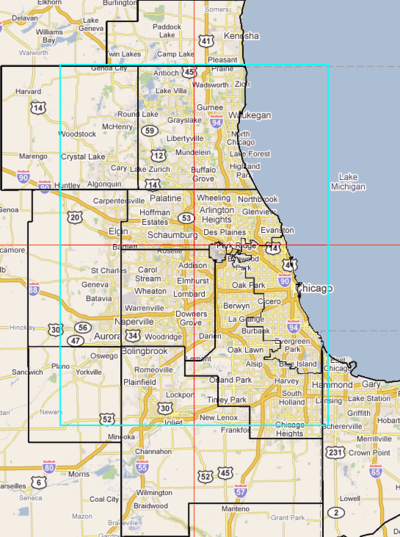

In [11]:
def validate_coordinates() -> None:
    """Display data scatter points vs active station locations on a map of chicago"""
    longitudes = pd.concat([df['start_lng'], df['end_lng']])
    latitudes = pd.concat([df['start_lat'], df['end_lat']])
    chicago_map = gpd.read_file('C:/Users/shrey/Downloads/Cyclistic Data Study/-fb6e-4db5-b8e4-c5e35746342e.shp')



    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))

    official_geometry = [Point(xy) for xy in zip(stations_df['Longitude'], stations_df['Latitude'])]
    main_geometry = [Point(xy) for xy in zip(longitudes, latitudes)]

    main_gdf = gpd.GeoDataFrame(crs="EPSG:4326", geometry = main_geometry)
    official_gdf = gpd.GeoDataFrame(crs="EPSG:4326", geometry = official_geometry)

    chicago_map.plot(ax = ax1, alpha = 0.4, color = 'grey')
    main_gdf.plot(ax = ax1, markersize = 3, color = "blue", marker = "o", label = "start/end bike points")
    chicago_map.plot(ax = ax2, alpha = 0.4, color = 'grey')
    official_gdf.plot(ax = ax2, markersize = 3, color = "red", marker = "s", label = "active docking stations")

    ax1.set(xlabel = "longitude", ylabel = "latitude")
    ax1.set_title('Locations of start/stop bike trips (July 2020 - June 2021)')
    ax2.set(xlabel = "longitude", ylabel = "latitude")
    ax2.set_title('Locations of Current Stations')
    ax1.legend(loc = 'upper right')
    ax2.legend(loc = 'upper right')
    
validate_coordinates()

DriverError: Unable to open C:/Users/shrey/Downloads/Cyclistic Data Study/-fb6e-4db5-b8e4-c5e35746342e.shx or C:/Users/shrey/Downloads/Cyclistic Data Study/-fb6e-4db5-b8e4-c5e35746342e.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [13]:
cycle_new[['member_casual','rideable_type']].plot(kind='bar', x='member_casual', y='rideable_type')

TypeError: no numeric data to plot

Checking for duplicate values

In [12]:
print("Unique values per column")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

Unique values per column
ride_id: 551480
rideable_type: 2
started_at: 468441
ended_at: 467938
start_station_name: 619
start_station_id: 618
end_station_name: 622
end_station_id: 619
start_lat: 2504
start_lng: 2494
end_lat: 2558
end_lng: 2552
member_casual: 2


In [13]:
def get_inconsistent_ids_series() -> pd.Series:
    """Get a pandas series of stations sharing the same ID and their value counts"""
    start_ids_sr = df.groupby(['start_station_id','start_station_name']).size().rename_axis(index={'start_station_id': 'id', 'start_station_name': 'station_name'})
    end_ids_sr = df.groupby(['end_station_id','end_station_name']).size().rename_axis(index={'end_station_id': 'id', 'end_station_name': 'station_name'})

    vc1 = start_ids_sr.reset_index()['id'].value_counts()
    vc2 = end_ids_sr.reset_index()['id'].value_counts()

    start_ids_with_many_names = vc1[vc1 > 1].index
    end_ids_with_many_names = vc2[vc2 > 1].index

    start_mask = start_ids_sr.index.get_level_values(0).isin(start_ids_with_many_names)
    start_ids_sr[start_mask]
    end_mask = end_ids_sr.index.get_level_values(0).isin(end_ids_with_many_names)
    end_ids_sr[end_mask]

    return pd.concat([start_ids_sr[start_mask], end_ids_sr[end_mask]], axis = 0)

inconsistent_ids_series = get_inconsistent_ids_series()
print("Number of station IDs with more than one name associated with it:", len(inconsistent_ids_series))
inconsistent_ids_series.head(6)

Number of station IDs with more than one name associated with it: 4


id     station_name                    
656.0  Damen Ave & Walnut (Lake) St        260
       Damen Ave & Walnut (Lake) St (*)      6
658.0  Leavitt St & Division St            328
       Leavitt St & Division St (*)          3
dtype: int64

In [14]:
def get_duplicates(field: str) -> pd.DataFrame:
    """Display rows with duplicate ride_ids"""
    vc = df[field].value_counts()
    duplicate_index = vc[vc > 1].index.to_list()
    n_duplicates = len(duplicate_index)
    print(f"Number of duplicates for {field}: {n_duplicates}")
    if n_duplicates > 0:
        print("Sample rows:")
        mask = df[field].isin(duplicate_index)
        return df[mask].sort_values(by = field).head(4)
    return

get_duplicates('ride_id')

Number of duplicates for ride_id: 0


In [15]:
mask = (df['ended_at'] - df['started_at']) < pd.Timedelta("0 days")
print("Number of rows with negative ride durations:", len(df.loc[mask]))
df = df.loc[~mask]


Number of rows with negative ride durations: 1745


In [16]:
get_duplicates('ride_id')

Number of duplicates for ride_id: 0


In [17]:
print("Before:")
cols_mem_usage('rideable_type','member_casual')

# let's convert these low unique count columns into categories
df['rideable_type'] = df['rideable_type'].astype('category')
df['member_casual'] = df['member_casual'].astype('category')

print("After:")
cols_mem_usage('rideable_type','member_casual')


Before:
rideable_type total memory usage: 37.385848MB
member_casual total memory usage: 34.633305MB
After:
rideable_type total memory usage: 0.549981MB
member_casual total memory usage: 0.549969MB


In [18]:
# checking the number of non digit values in start_station_id and end_station_id
mask = (df['start_station_id'].astype(str).str.contains(pat = '[^0-9.]', regex = True)) & (df['start_station_id'].notnull())
print(f"unique values with characters in start_station_id: {df.loc[mask, 'start_station_id'].nunique()}")

mask = (df['end_station_id'].astype(str).str.contains(pat = '[^0-9.]', regex = True)) & (df['end_station_id'].notnull())
print(f"unique values with characters in end_station_id: {df.loc[mask, 'end_station_id'].nunique()}")

unique values with characters in start_station_id: 0
unique values with characters in end_station_id: 0


In [19]:
def get_inconsistent_stations_index() -> pd.Index:
    """Get a pandas index of stations IDs (start and end) that share multiple names"""
    start_station_ids_df = df.groupby(['start_station_name', 'start_station_id']).size()
    end_station_ids_df = df.groupby(['end_station_name', 'end_station_id']).size()
    vc1 = start_station_ids_df.reset_index()['start_station_name'].value_counts()
    vc2 = end_station_ids_df.reset_index()['end_station_name'].value_counts()
    starts = vc1[vc1 > 1].index
    ends = vc2[vc2 > 1].index
    return starts.union(ends)

inconsistent_stations = get_inconsistent_stations_index()

print("Number of inconsistent stations with more than one id:",len(inconsistent_stations))

Number of inconsistent stations with more than one id: 0


In [20]:
mask = inconsistent_stations.isin(stations_df.index)
mismatched_names = set(inconsistent_stations[~mask])
mismatched_names

set()

In [22]:
def get_mismatches_and_suggested_replacements_df() -> pd.DataFrame:
    """Find any mismatches to our helper active stations set and find out if they have any close relations to other IDs/names"""
    start_station_ids_df = df.groupby(['start_station_name', 'start_station_id']).size()
    end_station_ids_df = df.groupby(['end_station_name', 'end_station_id']).size()

    start_station_ids_df.index.set_names(['station_name', 'associated_id'], inplace=True)
    end_station_ids_df.index.set_names(['station_name', 'associated_id'], inplace=True)

    # tabulate total id frequency under each name
    station_ids_count_df = pd.concat([start_station_ids_df.rename("start"), end_station_ids_df.rename("end")], axis=1)
    station_ids_count_df["count"] = station_ids_count_df['start'] + station_ids_count_df['end']
    station_ids_count_df = station_ids_count_df.drop(['start', 'end'], axis = 1)

    clean_station_names = list(stations_df.index)
    global mismatches_dict
    
    for mismatch in mismatches_dict:
        associated_name = None 
        valid_associated_id = None
        # lists ids from most frequent to least frequent
        uncleaned_ids = station_ids_count_df.loc[mismatch].index.tolist()
        
        # try to find a valid id that lines up with the official set
        for id in uncleaned_ids:
            if re.match(r"[+-]?([0-9]*[.])?[0-9]+", str(id)) and stations_df.loc[stations_df["ID"] == int(id)].index.size > 0:
                associated_name = stations_df.loc[stations_df["ID"] == int(id)].index[0]
                valid_associated_id = id 
                break

        # get the three closest name matches from the official set 
        closest_names = difflib.get_close_matches(mismatch, clean_station_names, 3)
        change_id_to = None 
        change_name_to = None 

        # try to find an official name that lines up with the mismatch's based on id matching
        for name in closest_names:
            official_id = stations_df.loc[stations_df.index == name]["ID"][0]
            if str(official_id) in uncleaned_ids:
                change_id_to = official_id
                change_name_to = name
                break

        """ 
        if no closest names matched with their id, but an id associated with the mismatch did match up,
        check to see if the associated name has enough similarities with our mismatch. 
        if it does, we can say with some certainty that we've found our match.
        """
        if change_name_to is None and len(uncleaned_ids) > 0 and associated_name is not None:
            # check that the uncleaned name is largely within the official associated id name
            text = mismatch.split(" ")
            keywords = []
            for word in text:
                if len(word) > 3: # disregard small keywords like ave, st 
                    keywords.append(word)
            n_keywords = len(keywords)
            n_matches = 0 
            for keyword in keywords:
                if keyword in associated_name:
                    n_matches += 1 
            
            if n_matches == n_keywords:
                change_name_to = associated_name
                change_id_to = valid_associated_id 

        """
        by this point, if no matches were made, then neither an associated id or a 
        similar name is on the official list. In which case, we'll just assign the
        most common id and leave the name as is.
        """
        if change_id_to is None and change_name_to is None:
            # update to most common associated id since no match was found
            change_id_to = uncleaned_ids[0]
            # keep the name the same 
            change_name_to = mismatch

        mismatches_dict[mismatch] = {
            'uncleaned_ids': uncleaned_ids,
            'valid_associated_id': valid_associated_id,
            'associated_id_official_name': associated_name,
            'change_name_to': change_name_to,
            'change_id_to': change_id_to,
        }
    
    return pd.DataFrame.from_dict(mismatches_dict, orient = 'index')
    
mismatches_dict = dict.fromkeys(mismatched_names)

get_mismatches_and_suggested_replacements_df()

""
